DAY2_課題① Kickstarter Projects  
講師からいただいたアドバイスから以下を修正  
・カテゴリ変数をlabelEncorderを使用しているのをget_dummiesに変更  
・usd_goal_realは使用できる。  

DAY2で習った以下の内容を反映する。  
・ホールドアウト法を行い、現状の学習誤差、汎化誤差を求める。  
・過学習をしているか確認、している場合正則化  
・正規化、標準化、無相関化、白色化を行う。  
・ハイパーパラメータの探索を行う  
・DAY1後宿題提出時の精度と比較して性能が上がっているか確認  

# まとめ

### ■DAY1 モデル作成と性能評価
データの読み込み  
不要そうなパラメータの削除  
目的変数のカテゴリを円グラフで確認して成功と失敗のみ抽出（中止なども失敗としてもいい）  
目的変数をカテゴリから0,1に置き換え  
get_dummiesでカテゴリ変数を数値化、変数の数が一気に増える。  
ロジスティック回帰で学習、変数の数が多いため学習に時間がかかる。  
性能評価  

### ■DAY1 終了時点での予測精度は以下  
対数尤度 = -14.240  
正答率（Accuracy） = 58.771%  
適合率（Precision） = 71.708%  
再現率（Recall） = 50.934%  
F1値（F1-score） = 59.562%  

### ■DAY2 標準化したデータでホールドアウト法  
訓練誤差　MAE = 0.354  
汎化誤差  MAE = 0.354  
訓練誤差と汎化誤差の値に差がないので過学習は起きていない。  
↑　結果が良すぎる。何か間違えている。

### ■DAY2 標準化のみを行った結果は以下  
標準化を行うことで以下のように性能が上がった。  
対数尤度 = -14.240　⇒　-12.212  
正答率（Accuracy） = 58.771% ⇒ 64.644%  
適合率（Precision）= 71.708% ⇒ 66.667%  
再現率（Recall） = 50.934% ⇒ 81.378%  
F1値（F1-score） = 59.562% ⇒ 73.292%   
AccuracyとRecallが上がって、Precisionが少し下がった。  

投資目線で考えると  
Precision = 成功するプロジェクトの取りこぼしをしない率  
Recall = 投資したプロジェクトの成功率   
負けない投資をするのであればRecallが大きいほうが良い。  
ただ、投資金額は一律ではないので、大きい投資額のプロジェクトばかり予測を外していたら損をする。  
この辺りはリスク回避で外れ値となるような大きい金額のプロジェクトは失敗と最初から予測するなど必要かもしれない。   

### ■DAY2 残件  
L1正則化を使用してパラメータ数を減らす。  
SVMにて最適解を探す。  
汎化誤差がうまく出ていないのを直す。  

## ↓ ここからDAY1の内容

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

In [3]:
#正則化用のライブラリ
from sklearn.linear_model import LinearRegression #線形回帰のライブラリ
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [4]:
#ホールドアウト法
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数from IPython.display import display

In [5]:
#標準化
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### 1. データの読み込み
課題① Kickstarter Projects

In [6]:
df_kick = pd.read_csv("../../DAY5/4_kadai/kickstarter-projects/ks-projects-201801.csv")

# 表の表示
display(df_kick.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [7]:
#統計値の表示
df_kick.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [8]:
#欠損値の確認
display(df_kick.count())
#nameとusd pledgedが欠損あり

ID                  378661
name                378657
category            378661
main_category       378661
currency            378661
deadline            378661
goal                378661
launched            378661
pledged             378661
state               378661
backers             378661
country             378661
usd pledged         374864
usd_pledged_real    378661
usd_goal_real       378661
dtype: int64

In [9]:
#各列のデータタイプの確認
display(df_kick.dtypes)

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

■各データの内容確認  
ID                   ただのID  
name                 プロジェクト名  
category             プロジェクトの詳細カテゴリ  
main_category        プロジェクトの大カテゴリ  
currency             使用される通貨  
deadline             期限  
goal                 出資調達目標、この金額になったら成功  
launched             開始日  
pledged              現在の出資金  
state                プロジェクトの状態、結果、目的変数  
backers              支援者数  
country              プロジェクトが開かれた国  
usd pledged          USドル変換した現在の出資金(real有り無しは計算方法の違い)    
usd_pledged_real     USドル変換した現在の出資金  
usd_goal_real        USドル変換した目標金額  

■プロジェクト開始後にわかるデータ  
pledged              現在の出資金  
state                プロジェクトの状態、結果、目的変数  
backers              支援者数  
usd pledged          USドル変換した現在の出資金    
usd_pledged_real     USドル変換した現在の出資金  


In [10]:
#不要そうな項目を削除
df_kick = df_kick.drop("ID", axis=1)
df_kick = df_kick.drop("name", axis=1)
df_kick = df_kick.drop("category", axis=1)

#プロジェクトスタート後にわかる説明変数は削除
df_kick = df_kick.drop("pledged", axis=1)
df_kick = df_kick.drop("backers", axis=1)
df_kick = df_kick.drop("usd pledged", axis=1)
df_kick = df_kick.drop("usd_pledged_real", axis=1)

#goalとusd_goalは同じ数字を変換しただけのもの。単位がそろっているほうがいいのでgoalは使用しない。
df_kick = df_kick.drop("goal", axis=1)

In [11]:
#開始日、終了日から期間を求める。
df_kick['deadline'] = pd.to_datetime(df_kick['deadline'], errors = 'coerce')
df_kick['launched'] = pd.to_datetime(df_kick['launched'], errors = 'coerce')

df_kick['period'] = (df_kick['deadline'] - df_kick['launched']).dt.days

#不要になったdeadlineとlaunchedの列を削除します。
df_kick = df_kick.drop(['deadline', 'launched'], axis=1)

In [12]:
#目的変数となりうるstateの要素数確認
df_kick['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

([<matplotlib.patches.Wedge at 0x28530dfa630>,
 [Text(-0.0764938,1.09734,'failed'),
  Text(-0.346261,-1.04408,'successful'),
  Text(0.986675,-0.486285,'canceled'),
  Text(1.09375,-0.117068,'undefined'),
  Text(1.09841,-0.0592097,'live'),
  Text(1.09987,-0.0168463,'suspended')],
 [Text(-0.0417239,0.598548,'52.2%'),
  Text(-0.188869,-0.569498,'35.4%'),
  Text(0.538186,-0.265246,'10.2%'),
  Text(0.596592,-0.0638554,'0.9%'),
  Text(0.59913,-0.0322962,'0.7%'),
  Text(0.59993,-0.0091889,'0.5%')])

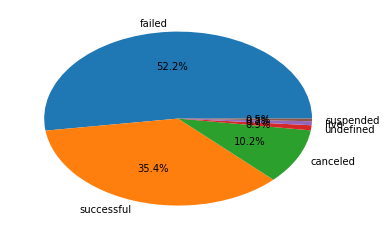

In [13]:
#要素の割合を円グラフで表示
plt.pie(df_kick['state'].value_counts(),autopct="%.1f%%", labels=df_kick['state'].value_counts().keys())

In [14]:
#ロジスティック回帰は2分割なので成功と失敗のみを抽出
df_kick_success = df_kick[df_kick['state']=='successful']
df_kick_failed =  df_kick[df_kick['state']=='failed']

#2つのデータを縦結合
df_kick_status = pd.concat([df_kick_success,df_kick_failed])

#カテゴリ変数を数値に置き換える
le = LabelEncoder()
#state
le = le.fit(df_kick_status['state'])
df_kick_status['state'] = le.transform(df_kick_status['state'])

In [15]:
#カテゴリデータのダミー数値化
df_kick_status = pd.get_dummies(df_kick_status)

In [16]:
#データの確認
display(df_kick_status.count())

state                         331675
usd_goal_real                 331675
period                        331675
main_category_Art             331675
main_category_Comics          331675
main_category_Crafts          331675
main_category_Dance           331675
main_category_Design          331675
main_category_Fashion         331675
main_category_Film & Video    331675
main_category_Food            331675
main_category_Games           331675
main_category_Journalism      331675
main_category_Music           331675
main_category_Photography     331675
main_category_Publishing      331675
main_category_Technology      331675
main_category_Theater         331675
currency_AUD                  331675
currency_CAD                  331675
currency_CHF                  331675
currency_DKK                  331675
currency_EUR                  331675
currency_GBP                  331675
currency_HKD                  331675
currency_JPY                  331675
currency_MXN                  331675
c

In [17]:
#取り敢えず何も考えずすべての変数で学習
y = df_kick_status['state'].values
X = df_kick_status.drop('state', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
print('W0= {:.3f}'.format(w0))
for i in range(len(clf.coef_[0])):
    print('w{} = {:.3f}'.format(i+1, clf.coef_[0, i]))

W0= 2633.667
w1 = -0.205
w2 = -134.699
w3 = -61.769
w4 = 598.543
w5 = -705.695
w6 = 278.162
w7 = 1081.198
w8 = -811.367
w9 = 1114.399
w10 = -366.092
w11 = 1110.717
w12 = -258.267
w13 = 1429.664
w14 = -342.932
w15 = -1139.692
w16 = -148.374
w17 = 855.173
w18 = -104.020
w19 = -25.168
w20 = 5.226
w21 = 16.888
w22 = -183.244
w23 = 646.347
w24 = 23.722
w25 = 0.317
w26 = -84.518
w27 = -6.023
w28 = -8.286
w29 = 2.298
w30 = 10.014
w31 = 2340.115
w32 = -5.388
w33 = -103.603
w34 = -7.197
w35 = -26.032
w36 = 5.226
w37 = -51.102
w38 = 15.437
w39 = -57.059
w40 = 60.135
w41 = 643.455
w42 = 23.722
w43 = -7.899
w44 = -88.951
w45 = 0.317
w46 = 2.470
w47 = -84.518
w48 = 9.260
w49 = -26.245
w50 = -6.011
w51 = -8.286
w52 = 2.479
w53 = 10.014
w54 = 2333.445


■識別精度を確認

In [18]:
#混同行列
# ラベルを予測
y_pred = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -14.240
正答率（Accuracy） = 58.771%
適合率（Precision） = 71.708%
再現率（Recall） = 50.934%
F1値（F1-score） = 59.562%


正答率は58%と低い。  

In [19]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,100707,97012
正解 = successful,39733,94223


## ↑ここまでDAY1の内容

## ↓ここからDAY2の内容

## ホールドアウト法と標準化

In [20]:
#ホールドアウト法
y = df_kick_status['state'].values
X = df_kick_status.drop('state', axis=1).values

# 全データのうち、30%をテストデータにする
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [21]:
#標準化
stdsc = StandardScaler()
X_train_stand = stdsc.fit_transform(X_train)
X_test_stand = stdsc.transform(X_test)

In [22]:
# 標準化した学習用データを使ってロジスティック回帰モデルを学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X_train_stand, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

## 訓練誤差

In [23]:
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train_stand)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
print("MAE = %s"%round(mae,3) )

MAE = 0.354


## 汎化誤差

In [24]:
# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test_stand)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE = %s"%round(mae,3) )

MAE = 0.354


訓練誤差と汎化誤差の値に差がないので過学習は起きていない。  
↑結果が良すぎる。何か間違えている。

## （残件）正則化
過学習対策としては今回行わない。  
パラメータ数削減として使用したいが使い方がわからずうまくいかなかったのでいったん削除。  

## 標準化したパラメータでモデル再作成し、評価

In [25]:
#取り敢えず何も考えずすべての変数で学習
y = df_kick_status['state'].values
X = df_kick_status.drop('state', axis=1).values
#標準化
stdsc = StandardScaler()
X_stand = stdsc.fit_transform(X)

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X_stand, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
print('W0= {:.3f}'.format(w0))
for i in range(len(clf.coef_[0])):
    print('w{} = {:.3f}'.format(i+1, clf.coef_[0, i]))

W0= -2.648
w1 = -16.656
w2 = -0.224
w3 = 0.023
w4 = 0.116
w5 = -0.113
w6 = 0.095
w7 = 0.049
w8 = -0.136
w9 = 0.049
w10 = -0.123
w11 = 0.060
w12 = -0.082
w13 = 0.153
w14 = -0.057
w15 = -0.096
w16 = -0.128
w17 = 0.155
w18 = -0.039
w19 = 0.762
w20 = 0.107
w21 = 9.357
w22 = -0.199
w23 = 0.403
w24 = 0.102
w25 = -109.261
w26 = 0.143
w27 = 0.051
w28 = 0.149
w29 = -0.160
w30 = 0.094
w31 = 0.441
w32 = 0.204
w33 = 0.691
w34 = 0.224
w35 = 0.140
w36 = 0.107
w37 = 0.563
w38 = -9.078
w39 = 0.410
w40 = 0.522
w41 = 1.019
w42 = 0.102
w43 = 0.255
w44 = 0.433
w45 = -109.261
w46 = 0.078
w47 = 0.143
w48 = 0.101
w49 = 0.467
w50 = 0.138
w51 = 0.149
w52 = 0.480
w53 = 0.094
w54 = 1.630


### 要検討
この時点で重みの少ないものは削除してもいい？  
L1正則化した後でないと決していいか判断できない？  

In [26]:
#混同行列
# ラベルを予測
y_pred = clf.predict(X_stand)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -12.212
正答率（Accuracy） = 64.644%
適合率（Precision） = 66.667%
再現率（Recall） = 81.378%
F1値（F1-score） = 73.292%


In [27]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,160900,36819
正解 = successful,80449,53507


### 標準化した結果
標準化を行うことで以下のように性能が上がった。  
対数尤度           = -14.240　⇒　-12.212  
正答率（Accuracy） = 58.771%  ⇒  64.644%  
適合率（Precision）= 71.708%  ⇒  66.667%  
再現率（Recall）   = 50.934%  ⇒  81.378%  
F1値（F1-score）   = 59.562%  ⇒  73.292%  

AccuracyとRecallが上がって、Precisionが少し下がった。  
投資目線で考えると  
Precision = 成功するプロジェクトの取りこぼしをしない率  
Recall = 投資したプロジェクトの成功率  

負けない投資をするのであればRecallが大きいほうが良い。  
ただ、投資金額は一律ではないので、大きい投資額のプロジェクトばかり予測を外していたら損をする。  
この辺りはリスク回避で外れ値となるような大きい金額のプロジェクトは失敗と最初から予測するなど必要かもしれない。  

## SVC
時間切れでできず。次回実装。